In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, random_split
import torch
from torch import optim
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import logging
from evaluate import evaluate

import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import OrderedDict

from model.ensemblenet_model import EnsembleNet


from utils.dice_score import dice_loss
from utils.data_load import KittiDataset
from torchsummaryX import summary

In [2]:
Val_Percent = 0.3
Scale_Percent = 1.0
Batch_Size = 8
learning_rate = 0.0001
Pin_Memory = False
epochs = 50


Image_Size = [384, 1216]
Gradient_Clipping = 0.8


Num_Class = 2
Num_Channel = 3
amp = True

Model_Name = 'ensemble_fusion'


Img_Path =  'data/data_road/training/image_2'
Mask_Path =  'data/data_road/training/semantic'

save_checkpoint = True
checkpoint_dir = '../trained' + '_' + Model_Name
batch_size = Batch_Size

In [3]:
dirImg = Path(Img_Path)
dirMask = Path(Mask_Path)
dir_checkpoint = Path(checkpoint_dir)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent)
n_val = int(len(datasets) * Val_Percent)
n_train = len(datasets) - n_val
train_set, val_set = random_split(datasets, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=Batch_Size, num_workers= os.cpu_count(), pin_memory=Pin_Memory)
train_loader = DataLoader(train_set, shuffle=True, drop_last = True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

100%|██████████| 289/289 [00:00<00:00, 790.20it/s]


In [6]:
model = EnsembleNet(Model_Name, Num_Channel, Num_Class)
model = model.to(memory_format=torch.channels_last, device = device)

In [7]:
# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)

if 'ensemble_voting' in Model_Name:
    unet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    segnet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    enet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    optims = [unet_optimizer, segnet_optimizer, enet_optimizer]
    
    unet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(unet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    segnet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(segnet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    enet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(enet_optimizer, 'max', patience=2)  # goal: maximize Dice score
       
else:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-10)
    #optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-10)
    optims = [optimizer]
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score

grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss()
global_step = 0

In [8]:
def calculate_loss(pred, true_masks, nclass, multiclass):
    loss = criterion(pred, true_masks)
    loss += dice_loss(
        F.softmax(pred, dim=1).float(),
        F.one_hot(true_masks, nclass).permute(0, 3, 1, 2).float(),
        multiclass=multiclass
    )
    return loss

def grad_forback(models, losses, optim):
    optim.zero_grad(set_to_none=True)
    grad_scaler.scale(losses).backward()
    torch.nn.utils.clip_grad_norm_(models.parameters(), Gradient_Clipping)
    grad_scaler.step(optim)
    grad_scaler.update()    

def forward_and_backward(model, images, true_masks, amp, optimizers, grad_scaler, model_name):
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        
        try:
            mn_cls = model.n_classes
        except:
            mn_cls = model.classifier[-1].out_channels

        if model_name == 'ensemble_voting':
            unet_pred, segnet_pred, enet_pred = model(images)
            #deeplab_pred = deeplab_pred['out']
            
            unet_loss = calculate_loss(unet_pred, true_masks, mn_cls, multiclass=True)
            segnet_loss = calculate_loss(segnet_pred, true_masks, mn_cls, multiclass=True)
            enet_loss = calculate_loss(enet_pred, true_masks, mn_cls, multiclass=True)
            
            
        else:
            masks_pred = model(images)
            if isinstance(masks_pred, OrderedDict):
                masks_pred = masks_pred['out']
            loss = calculate_loss(masks_pred, true_masks, mn_cls, multiclass=True)
    
    
    if model_name == 'ensemble_voting':
        for _loss, _optiz in zip([unet_loss, segnet_loss, enet_loss], optimizers):
            grad_forback(model, _loss, _optiz)

        return model, unet_loss, segnet_loss, enet_loss
    else:
        for _loss, _optiz in zip([loss], optimizers):
            grad_forback(model, _loss, _optiz)
            
        return model, loss


In [9]:
valScore_list1 = []
TrainLoss_list1 = []

valScore_list2 = []
TrainLoss_list2 = []

valScore_list3 = []
TrainLoss_list3 = []

valScore_list4 = []
TrainLoss_list4 = []

val_losses = []
val_accs = []
val_mious = []

# 5. Begin training
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    epoch_unet_loss = 0
    epoch_segnet_loss = 0
    epoch_enet_loss = 0
    epoch_voting_loss = 0
    
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            images, true_masks = batch['image'], batch['mask']

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

                
            result = forward_and_backward(model, images, true_masks, amp, optims, grad_scaler, Model_Name)
            
            if len(result) == 4:
                model, unet_loss, segnet_loss, enet_loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_unet_loss += unet_loss.item()
                epoch_segnet_loss += segnet_loss.item()
                epoch_enet_loss += enet_loss.item()
                vot_loss = ((unet_loss.item() + segnet_loss.item() + enet_loss.item()) /3)
                epoch_voting_loss += vot_loss
                
                
            elif len(result) == 2:
                model, loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()


        print('***')
        if len(result) == 4:
            print('Unet Loss: {}     Segnet Loss: {}     Enet Loss: {}'.format(unet_loss, segnet_loss, enet_loss))
            print('Voting Loss: {}'.format(vot_loss))
            
            
        elif len(result) == 2:
            print('{} Loss: {}'.format(Model_Name, loss))

        # Evaluation round
        division_step = (n_train // (5 * batch_size))
        if division_step > 0:
            #if global_step % division_step == 0:
            if len(result) == 4:
                unet_val_score, segnet_val_score, enet_val_score, voting_val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                unet_scheduler.step(unet_val_score)
                segnet_scheduler.step(segnet_val_score)
                enet_scheduler.step(enet_val_score)
                #voting_scheduler.step(voting_val_score)
                
                valScore_list1.append(unet_val_score.cpu().detach().numpy())
                TrainLoss_list1.append(unet_loss.cpu().detach().numpy())
                valScore_list2.append(segnet_val_score.cpu().detach().numpy())
                TrainLoss_list2.append(segnet_loss.cpu().detach().numpy())                
                valScore_list3.append(enet_val_score.cpu().detach().numpy())
                TrainLoss_list3.append(enet_loss.cpu().detach().numpy())
                valScore_list4.append(voting_val_score.cpu().detach().numpy())
                TrainLoss_list4.append(vot_loss)
                
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)
                
                print('---')
                print('Unet Validation Dice Score: {}     Segnet Validation Dice Score: {}     Enet Validation Dice Score: {}'.format(unet_val_score, segnet_val_score, enet_val_score))
                print('---')
                print('Ensemble Voting Validation Dice Loss: {}'.format(val_loss))
                print('Ensemble Voting Validation Pixel Accuracy: {} '.format(val_acc))
                print('Ensemble Voting Validation MIoU: {}'.format(val_miou))                
                print('Ensemble Voting Validation Dice Score: {} '.format(voting_val_score))
                
            else:
                val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                                
                scheduler.step(val_score)
                
                print('---')
                print('{} Validation Dice Loss: {}'.format(Model_Name, val_loss))   
                print('{} Validation Pixel Accuracy: {}'.format(Model_Name, val_acc))
                print('{} Validation MIoU: {}'.format(Model_Name, val_miou))
                print('{} Validation Dice Score: {}'.format(Model_Name, val_score))
                
            
                valScore_list1.append(val_score.cpu().detach().numpy())
                TrainLoss_list1.append(loss.cpu().detach().numpy())
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)

        
    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch + 1)))

Epoch 1/50:  99%|█████████▊| 200/203 [00:17<00:00, 15.20img/s]

***
ensemble_fusion Loss: 0.8195744752883911


Epoch 1/50:  99%|█████████▊| 200/203 [00:21<00:00,  9.11img/s]

---
ensemble_fusion Validation Dice Loss: 0.954772412776947
ensemble_fusion Validation Pixel Accuracy: 0.8505417673211348
ensemble_fusion Validation MIoU: 0.42527088366056753
ensemble_fusion Validation Dice Score: 1.3668949652712037e-11



Epoch 2/50:  99%|█████████▊| 200/203 [00:16<00:00, 15.02img/s]

***
ensemble_fusion Loss: 0.6986284255981445


Epoch 2/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.65img/s]

---
ensemble_fusion Validation Dice Loss: 0.7781057953834534
ensemble_fusion Validation Pixel Accuracy: 0.8619202730948465
ensemble_fusion Validation MIoU: 0.6629271345444556
ensemble_fusion Validation Dice Score: 0.7173851728439331



Epoch 3/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.09img/s]

***
ensemble_fusion Loss: 0.6108047366142273


Epoch 3/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.31img/s]

---
ensemble_fusion Validation Dice Loss: 0.6679369211196899
ensemble_fusion Validation Pixel Accuracy: 0.9051013076514528
ensemble_fusion Validation MIoU: 0.7422106901353653
ensemble_fusion Validation Dice Score: 0.7686667442321777



Epoch 4/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.18img/s]

***
ensemble_fusion Loss: 0.5138794183731079


Epoch 4/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.25img/s]

---
ensemble_fusion Validation Dice Loss: 0.555486798286438
ensemble_fusion Validation Pixel Accuracy: 0.9295940733792489
ensemble_fusion Validation MIoU: 0.7889036818597782
ensemble_fusion Validation Dice Score: 0.8214287161827087



Epoch 5/50:  99%|█████████▊| 200/203 [00:16<00:00, 14.89img/s]

***
ensemble_fusion Loss: 0.5143780708312988


Epoch 5/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.81img/s]

---
ensemble_fusion Validation Dice Loss: 0.5769665837287903
ensemble_fusion Validation Pixel Accuracy: 0.9304426762095669
ensemble_fusion Validation MIoU: 0.7933229954971459
ensemble_fusion Validation Dice Score: 0.8233925104141235



Epoch 6/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.01img/s]

***
ensemble_fusion Loss: 0.5079169869422913


Epoch 6/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.35img/s]

---
ensemble_fusion Validation Dice Loss: 0.5351046919822693
ensemble_fusion Validation Pixel Accuracy: 0.9405621980365954
ensemble_fusion Validation MIoU: 0.817117269861978
ensemble_fusion Validation Dice Score: 0.844199001789093



Epoch 7/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.16img/s]

***
ensemble_fusion Loss: 0.5132956504821777


Epoch 7/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.23img/s]

---
ensemble_fusion Validation Dice Loss: 0.4959312379360199
ensemble_fusion Validation Pixel Accuracy: 0.9534400806092379
ensemble_fusion Validation MIoU: 0.8450451925638884
ensemble_fusion Validation Dice Score: 0.8558929562568665



Epoch 8/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.91img/s]

***
ensemble_fusion Loss: 0.4803867042064667


Epoch 8/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.04img/s]

---
ensemble_fusion Validation Dice Loss: 0.5043696761131287
ensemble_fusion Validation Pixel Accuracy: 0.9473022996333608
ensemble_fusion Validation MIoU: 0.8127672150091441
ensemble_fusion Validation Dice Score: 0.8093054890632629



Epoch 9/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.92img/s]

***
ensemble_fusion Loss: 0.44173991680145264


Epoch 9/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.22img/s]

---
ensemble_fusion Validation Dice Loss: 0.48955145478248596
ensemble_fusion Validation Pixel Accuracy: 0.9508640222382128
ensemble_fusion Validation MIoU: 0.8379684377439537
ensemble_fusion Validation Dice Score: 0.8689016699790955



Epoch 10/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.08img/s]

***
ensemble_fusion Loss: 0.43795305490493774


Epoch 10/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.18img/s]

---
ensemble_fusion Validation Dice Loss: 0.5053102970123291
ensemble_fusion Validation Pixel Accuracy: 0.9436958714535362
ensemble_fusion Validation MIoU: 0.8247010499105347
ensemble_fusion Validation Dice Score: 0.8658649325370789



Epoch 11/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.91img/s]

***
ensemble_fusion Loss: 0.41464659571647644


Epoch 11/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.25img/s]

---
ensemble_fusion Validation Dice Loss: 0.46186959743499756
ensemble_fusion Validation Pixel Accuracy: 0.9582530239172149
ensemble_fusion Validation MIoU: 0.8599712696749726
ensemble_fusion Validation Dice Score: 0.8881329894065857



Epoch 12/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.80img/s]

***
ensemble_fusion Loss: 0.41899245977401733


Epoch 12/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.24img/s]

---
ensemble_fusion Validation Dice Loss: 0.4511704444885254
ensemble_fusion Validation Pixel Accuracy: 0.96075439453125
ensemble_fusion Validation MIoU: 0.8665229854141732
ensemble_fusion Validation Dice Score: 0.8821296095848083



Epoch 13/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.85img/s]

***
ensemble_fusion Loss: 0.4132254719734192


Epoch 13/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.16img/s]

---
ensemble_fusion Validation Dice Loss: 0.44920554757118225
ensemble_fusion Validation Pixel Accuracy: 0.9566342537863213
ensemble_fusion Validation MIoU: 0.857418535045813
ensemble_fusion Validation Dice Score: 0.8955747485160828



Epoch 14/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.84img/s]

***
ensemble_fusion Loss: 0.39586779475212097


Epoch 14/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.05img/s]

---
ensemble_fusion Validation Dice Loss: 0.43986672163009644
ensemble_fusion Validation Pixel Accuracy: 0.9634169193736294
ensemble_fusion Validation MIoU: 0.8737388753828956
ensemble_fusion Validation Dice Score: 0.8933555483818054



Epoch 15/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.75img/s]

***
ensemble_fusion Loss: 0.3742627501487732


Epoch 15/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.10img/s]

---
ensemble_fusion Validation Dice Loss: 0.44147002696990967
ensemble_fusion Validation Pixel Accuracy: 0.9585820248252467
ensemble_fusion Validation MIoU: 0.8593700139413167
ensemble_fusion Validation Dice Score: 0.8977641463279724



Epoch 16/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.87img/s]

***
ensemble_fusion Loss: 0.3770848512649536


Epoch 16/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.24img/s]

---
ensemble_fusion Validation Dice Loss: 0.4506065249443054
ensemble_fusion Validation Pixel Accuracy: 0.9468838875753838
ensemble_fusion Validation MIoU: 0.8319569567665155
ensemble_fusion Validation Dice Score: 0.8796764612197876



Epoch 17/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.02img/s]

***
ensemble_fusion Loss: 0.38526779413223267


Epoch 17/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.32img/s]

---
ensemble_fusion Validation Dice Loss: 0.42329198122024536
ensemble_fusion Validation Pixel Accuracy: 0.9563483522649396
ensemble_fusion Validation MIoU: 0.8572322114584371
ensemble_fusion Validation Dice Score: 0.8898364901542664



Epoch 18/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.94img/s]

***
ensemble_fusion Loss: 0.3767142593860626


Epoch 18/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.32img/s]

---
ensemble_fusion Validation Dice Loss: 0.4261507987976074
ensemble_fusion Validation Pixel Accuracy: 0.9542621813322368
ensemble_fusion Validation MIoU: 0.8533725882989258
ensemble_fusion Validation Dice Score: 0.8827086687088013



Epoch 19/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.07img/s]

***
ensemble_fusion Loss: 0.3462426960468292


Epoch 19/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.20img/s]

---
ensemble_fusion Validation Dice Loss: 0.3958815336227417
ensemble_fusion Validation Pixel Accuracy: 0.9649674265008223
ensemble_fusion Validation MIoU: 0.877594130229725
ensemble_fusion Validation Dice Score: 0.9136292338371277



Epoch 20/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.68img/s]

***
ensemble_fusion Loss: 0.3445087969303131


Epoch 20/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.10img/s]

---
ensemble_fusion Validation Dice Loss: 0.39173662662506104
ensemble_fusion Validation Pixel Accuracy: 0.966375518263432
ensemble_fusion Validation MIoU: 0.8828435634609385
ensemble_fusion Validation Dice Score: 0.9168217778205872



Epoch 21/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.07img/s]

***
ensemble_fusion Loss: 0.33398061990737915


Epoch 21/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.23img/s]

---
ensemble_fusion Validation Dice Loss: 0.39287954568862915
ensemble_fusion Validation Pixel Accuracy: 0.965772126850329
ensemble_fusion Validation MIoU: 0.8815712449625224
ensemble_fusion Validation Dice Score: 0.91447514295578



Epoch 22/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.11img/s]

***
ensemble_fusion Loss: 0.3318058252334595


Epoch 22/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.21img/s]

---
ensemble_fusion Validation Dice Loss: 0.387820303440094
ensemble_fusion Validation Pixel Accuracy: 0.9682261149088541
ensemble_fusion Validation MIoU: 0.8881351617875493
ensemble_fusion Validation Dice Score: 0.9187154173851013



Epoch 23/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.62img/s]

***
ensemble_fusion Loss: 0.3517034649848938


Epoch 23/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.23img/s]

---
ensemble_fusion Validation Dice Loss: 0.4012206196784973
ensemble_fusion Validation Pixel Accuracy: 0.9631548429790296
ensemble_fusion Validation MIoU: 0.875731030094705
ensemble_fusion Validation Dice Score: 0.9159676432609558



Epoch 24/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.94img/s]

***
ensemble_fusion Loss: 0.331026554107666


Epoch 24/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.28img/s]

---
ensemble_fusion Validation Dice Loss: 0.38990217447280884
ensemble_fusion Validation Pixel Accuracy: 0.966037951017681
ensemble_fusion Validation MIoU: 0.882673167970287
ensemble_fusion Validation Dice Score: 0.916726291179657



Epoch 25/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.92img/s]

***
ensemble_fusion Loss: 0.33506259322166443


Epoch 25/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.27img/s]

---
ensemble_fusion Validation Dice Loss: 0.3845749497413635
ensemble_fusion Validation Pixel Accuracy: 0.9687103806880483
ensemble_fusion Validation MIoU: 0.8910235979097041
ensemble_fusion Validation Dice Score: 0.9208739399909973



Epoch 26/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.11img/s]

***
ensemble_fusion Loss: 0.34013932943344116


Epoch 26/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.21img/s]

---
ensemble_fusion Validation Dice Loss: 0.3907182812690735
ensemble_fusion Validation Pixel Accuracy: 0.9658481530975878
ensemble_fusion Validation MIoU: 0.8829873578548642
ensemble_fusion Validation Dice Score: 0.9161767363548279



Epoch 27/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.98img/s]

***
ensemble_fusion Loss: 0.32775142788887024


Epoch 27/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.17img/s]

---
ensemble_fusion Validation Dice Loss: 0.38705509901046753
ensemble_fusion Validation Pixel Accuracy: 0.9661174573396382
ensemble_fusion Validation MIoU: 0.8831470589158867
ensemble_fusion Validation Dice Score: 0.9184722304344177



Epoch 28/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.89img/s]

***
ensemble_fusion Loss: 0.34053677320480347


Epoch 28/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.22img/s]

---
ensemble_fusion Validation Dice Loss: 0.38284575939178467
ensemble_fusion Validation Pixel Accuracy: 0.9678829260039747
ensemble_fusion Validation MIoU: 0.8884227406680822
ensemble_fusion Validation Dice Score: 0.9213955998420715



Epoch 29/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.91img/s]

***
ensemble_fusion Loss: 0.3188505470752716


Epoch 29/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.32img/s]

---
ensemble_fusion Validation Dice Loss: 0.37965092062950134
ensemble_fusion Validation Pixel Accuracy: 0.9697522615131579
ensemble_fusion Validation MIoU: 0.8933718397686208
ensemble_fusion Validation Dice Score: 0.9229737520217896



Epoch 30/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.99img/s]

***
ensemble_fusion Loss: 0.32503801584243774


Epoch 30/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.23img/s]

---
ensemble_fusion Validation Dice Loss: 0.37399864196777344
ensemble_fusion Validation Pixel Accuracy: 0.9699669553522479
ensemble_fusion Validation MIoU: 0.8935511992770275
ensemble_fusion Validation Dice Score: 0.9197880029678345



Epoch 31/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.87img/s]

***
ensemble_fusion Loss: 0.3249681293964386


Epoch 31/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.25img/s]

---
ensemble_fusion Validation Dice Loss: 0.38192611932754517
ensemble_fusion Validation Pixel Accuracy: 0.9663648103412829
ensemble_fusion Validation MIoU: 0.8830769768334468
ensemble_fusion Validation Dice Score: 0.9228429794311523



Epoch 32/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.99img/s]

***
ensemble_fusion Loss: 0.3217045068740845


Epoch 32/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.23img/s]

---
ensemble_fusion Validation Dice Loss: 0.37819138169288635
ensemble_fusion Validation Pixel Accuracy: 0.9684868528131854
ensemble_fusion Validation MIoU: 0.8900045784754291
ensemble_fusion Validation Dice Score: 0.9244740605354309



Epoch 33/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.92img/s]

***
ensemble_fusion Loss: 0.3149572014808655


Epoch 33/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.20img/s]

---
ensemble_fusion Validation Dice Loss: 0.37629032135009766
ensemble_fusion Validation Pixel Accuracy: 0.9681634735642818
ensemble_fusion Validation MIoU: 0.8888887525981601
ensemble_fusion Validation Dice Score: 0.9233312010765076



Epoch 34/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.78img/s]

***
ensemble_fusion Loss: 0.32647591829299927


Epoch 34/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.20img/s]

---
ensemble_fusion Validation Dice Loss: 0.38905733823776245
ensemble_fusion Validation Pixel Accuracy: 0.9633347360711348
ensemble_fusion Validation MIoU: 0.8761343012843951
ensemble_fusion Validation Dice Score: 0.9215243458747864



Epoch 35/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.75img/s]

***
ensemble_fusion Loss: 0.3132678270339966


Epoch 35/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.19img/s]

---
ensemble_fusion Validation Dice Loss: 0.38112616539001465
ensemble_fusion Validation Pixel Accuracy: 0.9670394094366777
ensemble_fusion Validation MIoU: 0.8861840674321846
ensemble_fusion Validation Dice Score: 0.9230063557624817



Epoch 36/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.00img/s]

***
ensemble_fusion Loss: 0.3172110617160797


Epoch 36/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.89img/s]

---
ensemble_fusion Validation Dice Loss: 0.37686991691589355
ensemble_fusion Validation Pixel Accuracy: 0.9677959241365132
ensemble_fusion Validation MIoU: 0.8878505627985567
ensemble_fusion Validation Dice Score: 0.9251413345336914



Epoch 37/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.97img/s]

***
ensemble_fusion Loss: 0.32025155425071716


Epoch 37/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.19img/s]

---
ensemble_fusion Validation Dice Loss: 0.38106387853622437
ensemble_fusion Validation Pixel Accuracy: 0.9656248929207785
ensemble_fusion Validation MIoU: 0.8818618095731661
ensemble_fusion Validation Dice Score: 0.9199540019035339



Epoch 38/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.76img/s]

***
ensemble_fusion Loss: 0.3247019946575165


Epoch 38/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.12img/s]

---
ensemble_fusion Validation Dice Loss: 0.3780882954597473
ensemble_fusion Validation Pixel Accuracy: 0.9669831928453947
ensemble_fusion Validation MIoU: 0.8856484175592858
ensemble_fusion Validation Dice Score: 0.923980176448822



Epoch 39/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.95img/s]

***
ensemble_fusion Loss: 0.3157603144645691


Epoch 39/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.20img/s]

---
ensemble_fusion Validation Dice Loss: 0.3751983046531677
ensemble_fusion Validation Pixel Accuracy: 0.9681142171223959
ensemble_fusion Validation MIoU: 0.8883192107846261
ensemble_fusion Validation Dice Score: 0.9208059310913086



Epoch 40/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.78img/s]

***
ensemble_fusion Loss: 0.3164342939853668


Epoch 40/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.23img/s]

---
ensemble_fusion Validation Dice Loss: 0.3863704204559326
ensemble_fusion Validation Pixel Accuracy: 0.9653130246881854
ensemble_fusion Validation MIoU: 0.8815343091350171
ensemble_fusion Validation Dice Score: 0.9214210510253906



Epoch 41/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.00img/s]

***
ensemble_fusion Loss: 0.31543296575546265


Epoch 41/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.11img/s]

---
ensemble_fusion Validation Dice Loss: 0.37775248289108276
ensemble_fusion Validation Pixel Accuracy: 0.967372693513569
ensemble_fusion Validation MIoU: 0.8866140033772236
ensemble_fusion Validation Dice Score: 0.9229182600975037



Epoch 42/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.91img/s]

***
ensemble_fusion Loss: 0.3118181824684143


Epoch 42/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.10img/s]

---
ensemble_fusion Validation Dice Loss: 0.37461355328559875
ensemble_fusion Validation Pixel Accuracy: 0.9684836404365406
ensemble_fusion Validation MIoU: 0.8895356249094117
ensemble_fusion Validation Dice Score: 0.9226222038269043



Epoch 43/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.93img/s]

***
ensemble_fusion Loss: 0.31537187099456787


Epoch 43/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.33img/s]

---
ensemble_fusion Validation Dice Loss: 0.37003183364868164
ensemble_fusion Validation Pixel Accuracy: 0.9694770679139254
ensemble_fusion Validation MIoU: 0.8919144218737115
ensemble_fusion Validation Dice Score: 0.9245400428771973



Epoch 44/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.00img/s]

***
ensemble_fusion Loss: 0.3133016526699066


Epoch 44/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.26img/s]

---
ensemble_fusion Validation Dice Loss: 0.38484156131744385
ensemble_fusion Validation Pixel Accuracy: 0.9648991634971217
ensemble_fusion Validation MIoU: 0.8798578103528939
ensemble_fusion Validation Dice Score: 0.9214233756065369



Epoch 45/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.80img/s]

***
ensemble_fusion Loss: 0.31412601470947266


Epoch 45/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.27img/s]

---
ensemble_fusion Validation Dice Loss: 0.37122663855552673
ensemble_fusion Validation Pixel Accuracy: 0.9699731124074835
ensemble_fusion Validation MIoU: 0.8942222841527989
ensemble_fusion Validation Dice Score: 0.9257915616035461



Epoch 46/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.08img/s]

***
ensemble_fusion Loss: 0.31551676988601685


Epoch 46/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.25img/s]

---
ensemble_fusion Validation Dice Loss: 0.3791365921497345
ensemble_fusion Validation Pixel Accuracy: 0.9674216822574013
ensemble_fusion Validation MIoU: 0.8869237922525266
ensemble_fusion Validation Dice Score: 0.9227221608161926



Epoch 47/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.90img/s]

***
ensemble_fusion Loss: 0.3135198950767517


Epoch 47/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.11img/s]

---
ensemble_fusion Validation Dice Loss: 0.37603312730789185
ensemble_fusion Validation Pixel Accuracy: 0.9678355434484649
ensemble_fusion Validation MIoU: 0.8880161793977119
ensemble_fusion Validation Dice Score: 0.9250486493110657



Epoch 48/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.79img/s]

***
ensemble_fusion Loss: 0.3112495541572571


Epoch 48/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.20img/s]

---
ensemble_fusion Validation Dice Loss: 0.3707810044288635
ensemble_fusion Validation Pixel Accuracy: 0.970068145216557
ensemble_fusion Validation MIoU: 0.8938176889953928
ensemble_fusion Validation Dice Score: 0.9239091277122498



Epoch 49/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.91img/s]

***
ensemble_fusion Loss: 0.31217479705810547


Epoch 49/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.24img/s]

---
ensemble_fusion Validation Dice Loss: 0.3725908398628235
ensemble_fusion Validation Pixel Accuracy: 0.9686678166975055
ensemble_fusion Validation MIoU: 0.8897170029896065
ensemble_fusion Validation Dice Score: 0.9220649003982544



Epoch 50/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.94img/s]

***
ensemble_fusion Loss: 0.31027233600616455


Epoch 50/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.09img/s]

---
ensemble_fusion Validation Dice Loss: 0.37631577253341675
ensemble_fusion Validation Pixel Accuracy: 0.9682684112013432
ensemble_fusion Validation MIoU: 0.8890349943124825
ensemble_fusion Validation Dice Score: 0.9229179620742798


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
df = pd.DataFrame([TrainLoss_list1, val_losses, valScore_list1, val_accs, val_mious]).T
df.columns = ['train_loss', 'val_loss', 'val_score', 'val_acc', 'val_miou']
df.to_csv(checkpoint_dir + '/model_check.csv', encoding = 'UTF-8')

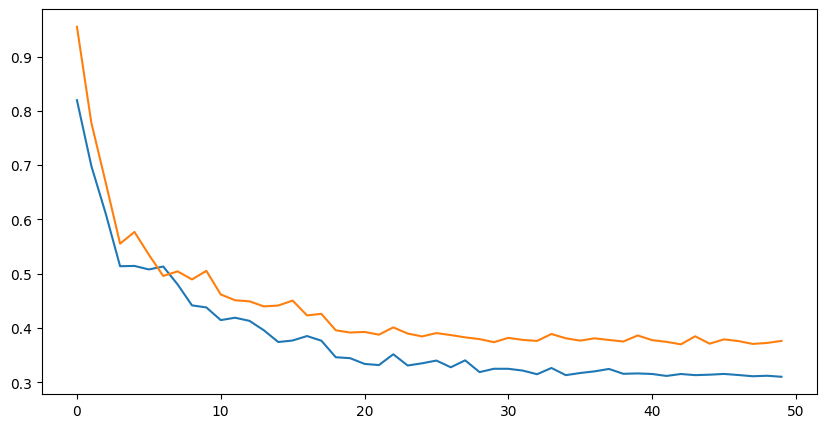

In [16]:
plt.figure(figsize= (10,5))
plt.plot(TrainLoss_list1)
plt.plot(val_losses)

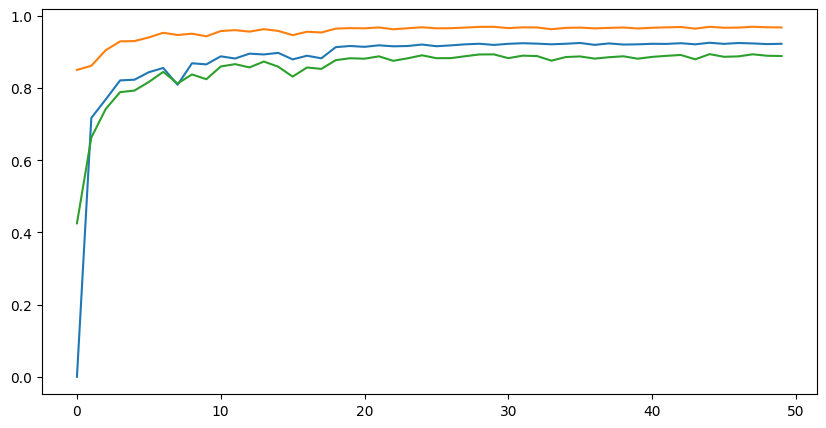

In [17]:
plt.figure(figsize= (10,5))
plt.plot(valScore_list1)
plt.plot(val_accs)
plt.plot(val_mious)